# Challenge Description
We got employee data from a few companies. We have data about all employees who joined
from 2011/01/24 to 2015/12/13. For each employee, we also know if they are still at the
company as of 2015/12/13 or they have quit. Beside that, we have general info about the
employee, such as avg salary during her tenure, dept, and yrs of experience.

The goal here is to predict employee retention and understand its main drivers.<br>
Specifically, you should:
* Assume, for each company, that the headcount starts from zero on 2011/01/23. Estimate
employee headcount, for each company, on each day, from 2011/01/24 to 2015/12/13.
That is, if by 2012/03/02 2000 people have joined company 1 and 1000 of them have
already quit, then company headcount on 2012/03/02 for company 1 would be 1000.
**You should create a table with 3 columns: day, employee_headcount, company_id.**
* What are the main factors that drive employee churn? Do they make sense? Explain your
findings.
* If you could add to this data set just one variable that could help explain employee churn,
what would that be?

# Data

There is one data file you will need to load (located in the data folder):

### problem1_data.csv

** Columns:**
* **employee_id** : id of the employee. Unique by employee per company
* **company_id** : company id.
* **dept** : employee dept
* **seniority** : number of yrs of work experience when hired
* **salary** : avg yearly salary of the employee during her tenure within the company
* **join_date** : when the employee joined the company, it can only be between 2011/01/24
and 2015/12/13
* **quit_date**: when the employee left her job (if she is still employed as of 2015/12/13, this
field is NA)


In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn.apionly as sns

%matplotlib inline

In [2]:
df = pd.read_csv('./data/problem1_data.csv')

In [3]:
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
employee_id    24702 non-null float64
company_id     24702 non-null int64
dept           24702 non-null object
seniority      24702 non-null int64
salary         24702 non-null float64
join_date      24702 non-null object
quit_date      13510 non-null object
dtypes: float64(2), int64(2), object(3)
memory usage: 1.3+ MB


In [5]:
# need to convert date columns, since they're current considered strings
# will need to be datetimes for what we're doing below
type(df.join_date.iloc[0])

str

In [6]:
df['join_date'] = pd.to_datetime(df.join_date)
df['quit_date'] = pd.to_datetime(df.quit_date)

### Goal 1: get headcount by company for every day between 2011/01/24 and 2015/12/13

Steps:
* Generate table that has entry for every company by every day in the date range
* Figure out how many people have joined and quit each company on each of those days
* Calculate running total of people that have joined and left each company
* Calculate headcount of people currently at company

** Step 1 **<br>
We essentially need the cartesian product of the unique company IDs and the dates in the date range. Below are two ways to achieve that

In [7]:
all_dates = pd.date_range('2011/01/24', '2015/12/13')
companies = sorted(df.company_id.unique())

#Using pandas merge. We need to generate a temporary key that we can use to 
#merge on. If this key has identical values, the result is the cartesian product
dates_df = pd.DataFrame({'day': all_dates, 'key': np.full(len(all_dates), 1)})
company_df = pd.DataFrame({'company_id': companies, 'key': np.full(len(companies), 1)})

headcount = pd.merge(dates_df, company_df, on='key', how='outer')
headcount.head()

,day,key,company_id
0,2011-01-24,1,1
1,2011-01-24,1,2
2,2011-01-24,1,3
3,2011-01-24,1,4
4,2011-01-24,1,5


In [8]:
headcount.tail()

,day,key,company_id
21415,2015-12-13,1,8
21416,2015-12-13,1,9
21417,2015-12-13,1,10
21418,2015-12-13,1,11
21419,2015-12-13,1,12


In [9]:
# we can then just drop the key column
headcount.drop('key', axis=1, inplace=True)
headcount.head()

,day,company_id
0,2011-01-24,1
1,2011-01-24,2
2,2011-01-24,3
3,2011-01-24,4
4,2011-01-24,5


In [10]:
#a second way to do this is to generate the final dataframe outright using itertools.product
#we can do this with a list comprehension and just pass column names to the dataframe constructor
#e.g.
product = [[date, company_id] for date, company_id in itertools.product(all_dates, companies)]
product[:5]

[[Timestamp('2011-01-24 00:00:00', freq='D'), 1],
 [Timestamp('2011-01-24 00:00:00', freq='D'), 2],
 [Timestamp('2011-01-24 00:00:00', freq='D'), 3],
 [Timestamp('2011-01-24 00:00:00', freq='D'), 4],
 [Timestamp('2011-01-24 00:00:00', freq='D'), 5]]

In [11]:
pd.DataFrame(product, columns=['day', 'company_id']).head()

,day,company_id
0,2011-01-24,1
1,2011-01-24,2
2,2011-01-24,3
3,2011-01-24,4
4,2011-01-24,5


In [12]:
pd.DataFrame(product, columns=['day', 'company_id']).tail()

,day,company_id
21415,2015-12-13,8
21416,2015-12-13,9
21417,2015-12-13,10
21418,2015-12-13,11
21419,2015-12-13,12


** Step 2**<br>
For this, we can use the knowledge that for any company the number of joined or quit on a particular day will simply be the number of entries for that company on that day in our original dataframe. 

In [13]:
# get group by the join date and company id and then calculate how many items are in that group
num_joined = (df.groupby(['join_date', 'company_id'])
                .apply(lambda x: len(x)).reset_index(name='num_joined'))
num_joined.head(5)

,join_date,company_id,num_joined
0,2011-01-24,1,25
1,2011-01-24,2,17
2,2011-01-24,3,9
3,2011-01-24,4,12
4,2011-01-24,5,5


In [14]:
num_quit = (df.groupby(['quit_date', 'company_id'])
              .apply(lambda x: len(x)).reset_index(name='num_quit'))
num_quit.head(5)

,quit_date,company_id,num_quit
0,2011-10-13,6,1
1,2011-10-14,10,1
2,2011-10-21,1,1
3,2011-10-28,4,1
4,2011-11-11,1,1


We can now merge these with headcount. Dates that exist in headcount that are not in num_joined or num_quit will be Nans, which we will replace with 0s

In [15]:
headcount = pd.merge(headcount, num_joined, how='left', 
                     left_on=['day', 'company_id'], right_on=['join_date', 'company_id'])

headcount = pd.merge(headcount, num_quit, how='left', 
                     left_on=['day', 'company_id'], right_on=['quit_date', 'company_id'])

headcount.num_joined.fillna(0, inplace=True)
headcount.num_quit.fillna(0, inplace=True)

In [16]:
headcount.head()

,day,company_id,join_date,num_joined,quit_date,num_quit
0,2011-01-24,1,2011-01-24,25.0,NaT,0.0
1,2011-01-24,2,2011-01-24,17.0,NaT,0.0
2,2011-01-24,3,2011-01-24,9.0,NaT,0.0
3,2011-01-24,4,2011-01-24,12.0,NaT,0.0
4,2011-01-24,5,2011-01-24,5.0,NaT,0.0


** Step 3 **<br>
We can now get the running total per company. Since the day column is in order, we can just use cumsum on the company groupby

In [17]:
headcount['join_cumsum'] = headcount.groupby(['company_id']).num_joined.cumsum()
headcount['quit_cumsum'] = headcount.groupby(['company_id']).num_quit.cumsum()

In [18]:
headcount.tail()

,day,company_id,join_date,num_joined,quit_date,num_quit,join_cumsum,quit_cumsum
21415,2015-12-13,8,NaT,0.0,NaT,0.0,1047.0,579.0
21416,2015-12-13,9,NaT,0.0,NaT,0.0,961.0,529.0
21417,2015-12-13,10,NaT,0.0,NaT,0.0,865.0,480.0
21418,2015-12-13,11,NaT,0.0,NaT,0.0,16.0,12.0
21419,2015-12-13,12,NaT,0.0,NaT,0.0,24.0,12.0


** Step 4 **<br>
And now we just take the difference of the two cumsum columns to get the current number of people at each company on that particular day

In [19]:
headcount['total']  = headcount.join_cumsum.sub(headcount.quit_cumsum, fill_value=0)

In [20]:
headcount.groupby('company_id').agg([max, min]).total

,max,min
company_id,,
1,3886.0,25.0
2,2016.0,17.0
3,1238.0,9.0
4,934.0,12.0
5,791.0,5.0
6,580.0,3.0
7,571.0,1.0
8,480.0,6.0
9,439.0,3.0


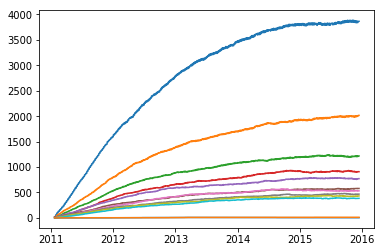

In [21]:
for name, group in headcount.groupby('company_id'):
    plt.plot(all_dates, group.total)

/usr/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


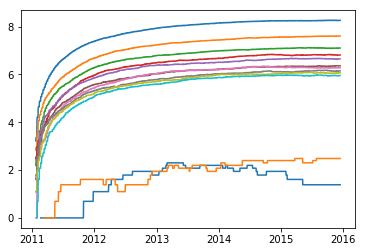

In [22]:
for name, group in headcount.groupby('company_id'):
    plt.plot(all_dates, np.log(group.total))

### Goal 2

Why are people leaving the company? Let's dig in to the data we have.

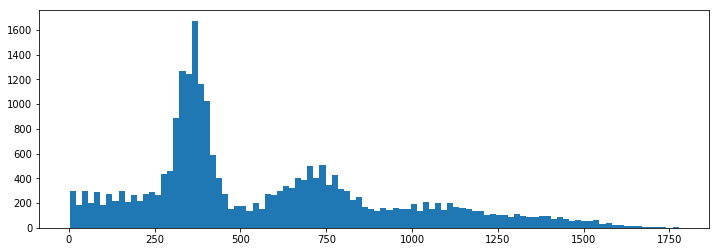

In [23]:
# let's look at how long most people are staying at their job
# remember that the nans in quit_date represent people who are still working
df['days_employed'] = df.quit_date.fillna(all_dates[-1]) - df.join_date
df.days_employed.dt.days.hist(bins=100, figsize=(12,4), grid=False)

In [24]:
# most number of days employed
print(df.days_employed.dt.days.value_counts().index[0])

# peak bin in histogram above
count, division = np.histogram(df.days_employed.dt.days, bins=100)
print(division[count.argmax()])

375
357.8


In [25]:
# second peak in distribution, most number of days employed
sub = df[df.days_employed.dt.days > 500]
print(sub.days_employed.dt.days.value_counts().index[0])

# peak bin in histogram above
count, division = np.histogram(sub.days_employed.dt.days, bins =100)
print(division[count.argmax()])

732
730.68


So, it seems there is a large portion of people that leave within a year. The second peak is around the two year mark, which makes sense.

What can we say about the people that quit? Are there noticeable differences between those who quit within the first year and those you left later (or are still employed)?

In [26]:
quitters = df[df.days_employed.dt.days <= 365]
lifers = df[df.days_employed.dt.days > 365]

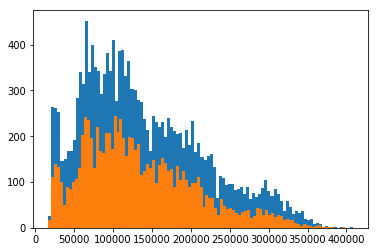

In [27]:
lifers.salary.hist(bins=100, grid=False)
quitters.salary.hist(bins=100, grid=False)

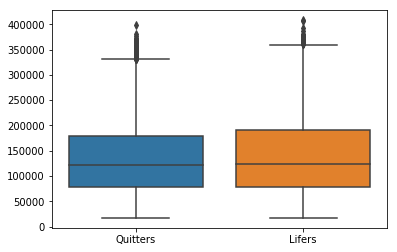

In [28]:
ax = sns.boxplot(data=np.array([quitters.salary.values, lifers.salary.values]))
ax.xaxis.set_ticklabels(['Quitters', 'Lifers'])

In [29]:
quitters.dept.value_counts()/len(quitters) * 100

customer_service    38.690682
engineer            17.665397
sales               13.485741
marketing           13.023900
data_science        11.927029
design               5.207251
Name: dept, dtype: float64

In [30]:
lifers.dept.value_counts()/len(lifers) * 100

customer_service    36.338134
engineer            19.219500
data_science        13.446793
marketing           12.711178
sales               12.492987
design               5.791410
Name: dept, dtype: float64

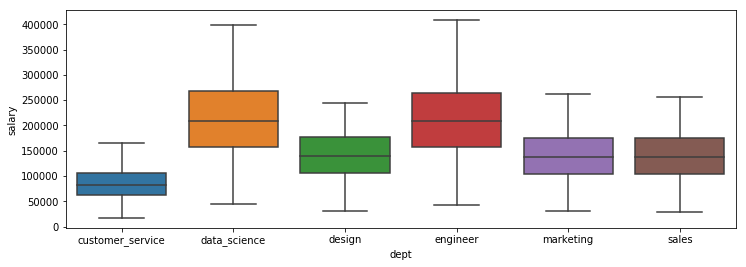

In [31]:
plt.figure(figsize=(12, 4))
x = df.sort_values(by='dept').dept
y = df.sort_values(by='dept').salary
sns.boxplot(x, y)

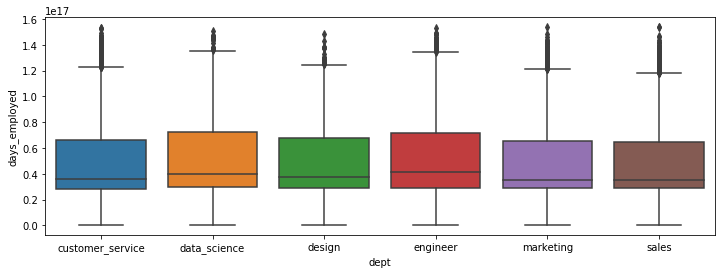

In [32]:
plt.figure(figsize=(12, 4))
x = df.sort_values(by='dept').dept
y = df.sort_values(by='dept').days_employed
sns.boxplot(x, y)

In [33]:
quitters.groupby('dept').salary.median()

dept
customer_service     85000.0
data_science        202000.0
design              137000.0
engineer            198000.0
marketing           138000.0
sales               140000.0
Name: salary, dtype: float64

In [34]:
lifers.groupby('dept').salary.median()

dept
customer_service     83000.0
data_science        212000.0
design              140000.0
engineer            215000.0
marketing           138000.0
sales               135000.0
Name: salary, dtype: float64

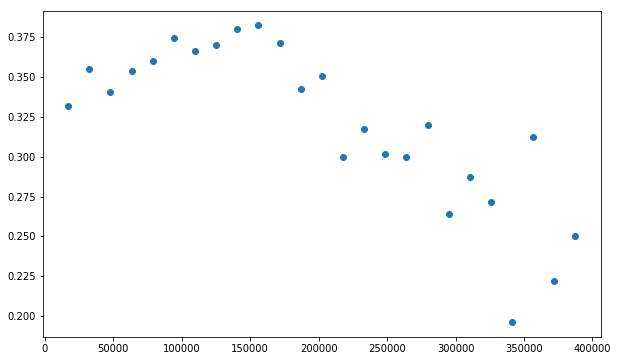

In [35]:
# let's look at the proportion of values at different salary levels that fall in to 
# the "early leaver" category

bins = np.linspace(df.salary.min(), df.salary.max()*0.95, 25)
df['early_leaver'] = df.days_employed.dt.days <= 365
df['bins'] = np.digitize(df.salary, bins)

plt.figure(figsize=(10, 6))
plt.plot(bins, df.groupby('bins').apply(lambda x: len(x[x.early_leaver])/len(x)), 'o')

## Some general conclusions

* People tend to leave near their yearly employment anniversary 
* Individuals with a higher salary are generally less likely to leave within the first year 